# Rev $\Delta \eta_{hh}$

**Goal:** Let's *do things* !!

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/']
from analysis import getXhh
from utils import mcToYr, L

from statUtils import calc_bstrap

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
yr = 17
mc = 'mc16d'

In [3]:
x1,y1 = 124,117

In [4]:
rw_cols = ['njets','pT_4','pT_2','dRjj_1','dRjj_2','eta_i','pt_hh','X_wt_tag','m_hh',
           'HT', 'dPhi_h1', 'dPhi_h2', 'dRjj_h1', 'dRjj_h2','dR_hh']

load_cols = ['dEta_hh','m_h1','m_h2','phi_h1','phi_h2','pass_vbf_sel'] 
load_cols += [f'{v}_h{i}_j{j}' for v,i,j in product(['pT','eta','phi'],[1,2],[1,2])]

In [5]:
wcols = [f'NN_d24_weight_bstrap_med_{yr}',
         f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
         f'NN_d24_weight_bstrap_IQR_{yr}']

cols = ['ntag'] + rw_cols[:9] + load_cols + wcols

In [6]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind/rev_deta'
rwTag = f'_NN_100_bootstraps'

with uproot.open(f'{fDir}/data/data{yr}{rwTag}.root') as f:

    try:

        # uproot3 syntax
        sr = f['sig'].pandas.df(cols)
        vr = f['validation'].pandas.df(cols)
        cr = f['control'].pandas.df(cols)

        norm     = f[f'NN_norm_bstrap_med_{yr}']._fVal
        norm_VR  = f[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal
        norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}']._fVal
               
    except:
        
        # uproot4 syntax
        sr = f['sig'].arrays(cols,library='pd')
        vr = f['validation'].arrays(cols,library='pd')
        cr = f['control'].arrays(cols,library='pd')   
        
        norm     = f[f'NN_norm_bstrap_med_{yr}'].all_members['fVal']
        norm_VR  = f[f'NN_norm_VRderiv_bstrap_med_{yr}'].all_members['fVal']
        norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}'].all_members['fVal']
        
for bdf in [sr,vr,cr]:
    bdf['w_2b'] = norm * bdf[f'NN_d24_weight_bstrap_med_{yr}']
    bdf['w_2b_VR'] = norm_VR * bdf[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']


*Also* open the SR df.

In [7]:
sFile = f'../data/RR/NNT_DEC20_MDR_VEC/MC/600043_{mc}/NanoNTuple.root'
tName = 'everything'

scols = ['ntag','X_wt','m_hh','mc_sf','truth_mhh'] + rw_cols[:7] + load_cols 
try:
    sdf = uproot.open(sFile)[tName].pandas.df(scols)
except:
    sdf = uproot.open(sFile)[tName].arrays(scols,library='pd')
    
# Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
sdf['mc_sf']     *= L[yr]
sdf['truth_mhh'] *= 0.001

sdf['Xhh_new'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)

sdf = sdf[(sdf.Xhh_new < 1.6) & (sdf.ntag>=4) & (~sdf.pass_vbf_sel) & (sdf.dEta_hh > 1.5)]

In [8]:
ti = "$\mathbf{ATLAS}$ "+f"20{yr} Data Internal\n"
ti += "min_dR, X_wt_tag, res bkts"

In [9]:
def evalRw(df, col, n, r, title='', xl='',mi=True,
           rlim=(0.5,1.5),vlines=[],sdf=None,scale=100,
           figDir='',label=''):


    fig, [ax1,ax2] = plt.subplots(2,1,figsize=(6, 6), 
                       gridspec_kw={"height_ratios": [.67, .33], 
                                    "hspace":0.1, "left":0.098, "bottom":0.09})

    m_2b = (df.ntag==2) & mi
    m_4b = (df.ntag>=4) & mi
    
    
    n_2b,e,_ = ax1.hist(df.loc[m_2b,col],n,r, histtype='stepfilled',
                         fc='darkturquoise',ec='k',label='CR rw 2b',
                        weights=df.loc[m_2b,'w_2b'])

    n_VR = np.histogram(df.loc[m_2b,col],n,r,
                        weights=df.loc[m_2b,'w_2b_VR'])[0]

    xx = 0.5 * (e[1:] + e[:-1])
    ax1.hist(xx,e, color='darkorange', histtype='step',
             weights=n_VR, lw=2, label='VR rw 2b')

    if type(mi) == bool:
        bs = calc_bstrap(df, col, yr, norm, norm_IQR,e)
    else:
        print('Running bs w/ corresponding mask')
        bs = calc_bstrap(df[mi], col, yr, norm, norm_IQR,e)
        
    err = np.sqrt( (n_2b-n_VR)**2 + bs**2 )
    
    ax1.fill_between(e,[0]+list(n_2b-err),[0]+list(n_2b+err), 
                     step='pre',facecolor='None',
                     edgecolor='dimgrey', hatch='\\\\\\\\', 
                     linewidth=0,zorder=5,label=r'BS+shape')
    
    n_4b = np.histogram(df.loc[m_4b,col],n,r)[0]

    ax1.errorbar(xx,n_4b,np.sqrt(n_4b),label='4b',
                 color='k',marker='o',lw=0,elinewidth=2)

    if sdf is not None:
        s = np.histogram(sdf[col],n,r,weights=sdf['mc_sf'])[0]
        s_err = np.sqrt(np.histogram(sdf[col],n,r,weights=sdf['mc_sf']**2)[0])
            
        s_up = scale*np.array([0]+list(s+s_err))
        s_dn = scale * np.array([0]+list(s-s_err))
        
        ax1.hist(xx,e,histtype='step',color='rebeccapurple',
                 lw=2,label=f'{scale} x SM',weights=scale*s)
    
    # Add lines to visualize the cuts
    ylim = ax1.get_ylim()
    for vl in vlines:
        ax1.plot([vl]*2,ylim,color='C3',ls='--')
    ax1.set_ylim(ylim)
    
    ax2.plot(xx,np.ones_like(xx),'k--')
       
    dn = [0] + list(1 - err[n_2b!=0]/n_2b[n_2b!=0])
    up = [0] + list(1 + err[n_2b!=0]/n_2b[n_2b!=0])
        
    ax2.fill_between([e[0]] + list(e[1:][n_2b!=0]),dn,up,
                     step='pre',facecolor='None',
                     edgecolor='dimgrey', hatch='\\\\\\\\', 
                     linewidth=0,zorder=5)
    ax2.errorbar(xx[n_2b!=0],n_4b[n_2b!=0]/n_2b[n_2b!=0],
                 np.sqrt(n_4b[n_2b!=0])/n_2b[n_2b!=0],label='4b',
                 color='k',marker='o',lw=0,elinewidth=2)

    ax2.scatter(xx[n_2b!=0],n_VR[n_2b!=0]/n_2b[n_2b!=0],
                 color='darkorange',marker='o',lw=0)

    ax2.set_ylim(rlim)


    ax1.legend(fontsize=18)
    ax2.set_xlabel(xl if xl else col,fontsize=18)
    ax1.set_ylabel('Entries',fontsize=18)
    ax2.set_ylabel('1 / rw 2b',fontsize=18)
    ax1.set_title(title,loc='right')

    fig.text(0,1,ti,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
    
    if figDir:
        plt.savefig(f'{figDir}/{col}{label}.pdf',bbox_inches='tight')
    

In [10]:
figDir = f'figures/data{yr}_sr_124_117/rev_deta_cats/'

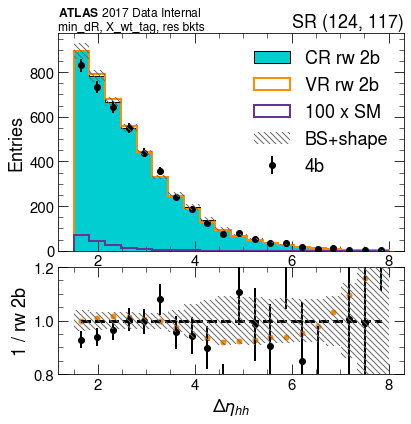

In [28]:
n,r = 20,(1.5,8)

evalRw(sr,'dEta_hh',n,r,f'SR (124, 117)','$\Delta \eta_{hh}$',rlim=(.8,1.2),
       sdf=sdf,figDir=figDir,label='_SR_100x_sig')

How can I divide up $\Delta \eta_{hh}$ such that I have a flat predicted rw distribution?

In [13]:
r = (1.5,7.5)

n,e = np.histogram(sr.loc[sr.ntag==2,'dEta_hh'],100,r,
                 weights=sr.loc[sr.ntag==2,'dEta_hh'])

y = np.add.accumulate(n)/np.sum(n)


In [14]:
plt.hist(0.5*(e[1:]+e[:-1]),e,color='hotpink',weights=n)
plt.show()

2.94


2.46
3.6


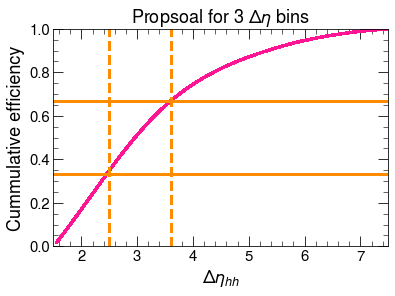

1.98
2.46
2.94
3.6
4.62


In [15]:
colors = ['royalblue','darkorange','limegreen']

var_bins = [
    [3],
    [2.5,3.6],
    [2,2.5,3,3.6,4.62]
]


for ci, nb, xis in zip(colors,[2,3,6],var_bins):
    
    plt.figure()
    
    plt.plot(e[1:],y,color='deeppink')
    plt.xlabel('$\Delta \eta_{hh}$',fontsize=18)
    plt.ylabel('Cummulative efficiency',fontsize=18)
    
    for yi in np.arange(1,nb)/nb:
        i=np.argmin(np.abs(y-yi))
        print(e[i+1])

        plt.plot(r,[yi]*2,ci)
  
    for xi in xis:
        plt.plot([xi]*2,[0,1],ci,ls='--')

    plt.xlim(r)
    plt.ylim(0,1)
    plt.title(f'Propsoal for {nb} $\Delta \eta$ bins')
    plt.show()
    #break

(array([164633.265625, 171934.796875, 157980.5625  , 151161.5     ,
        158073.3125  , 169192.375   ]),
 array([1.5 , 2.  , 2.5 , 3.  , 3.6 , 4.62, 8.  ]),
 <BarContainer object of 6 artists>)

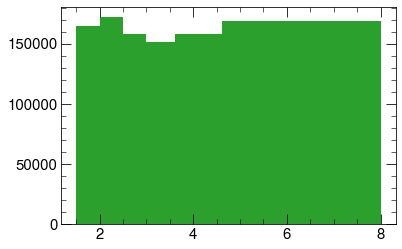

In [16]:
plt.hist(sr.loc[sr.ntag==2,'dEta_hh'],[1.5,2,2.5,3,3.6,4.62,8],
         color='C2',weights=sr.loc[sr.ntag==2,'dEta_hh'])

### Check inside / outside

In [17]:
for df in [sr,cr,cr]:
    df['Xhh_new'] = getXhh( *df[['m_h1','m_h2']].values.T, x1, y1)

Just sanity check 1.6 cut for SR.

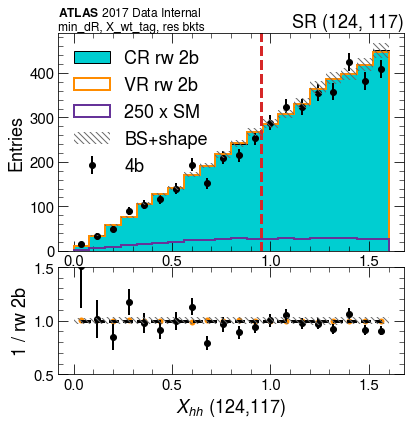

In [27]:
n,r = 20,(0,1.6)

evalRw(sr,'Xhh_new',n,r,f'SR (124, 117)','$X_{hh}$ (124,117)',vlines=[0.95],
       scale=250,sdf=sdf,figDir=figDir,label='_SR')

In [19]:
calc_bstrap(df, 'Xhh_new', yr, norm, norm_IQR,np.linspace(*r,n+1))

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/deta_cats/statUtils.py:37: RuntimeWarning: invalid value encountered in true_divide
  return abs(n_IQRup*np.sum(n2)/np.sum(n_IQRup)+n2*norm_IQR/2.-n2)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

**Goal:** I should vis the bs and the non-closure errors as a function of *where* we are in the massplane.

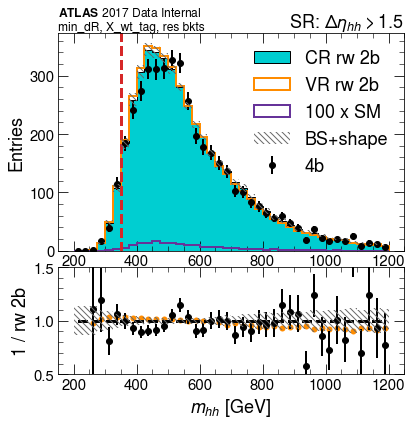

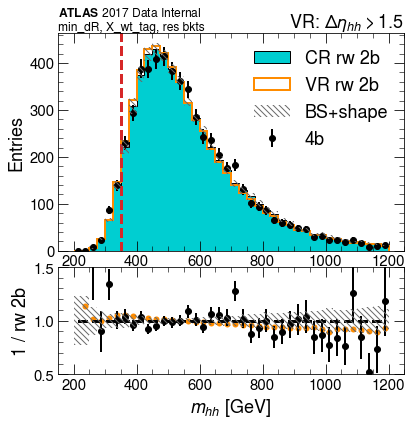

In [26]:
for df,region in zip([sr,vr,cr],['SR','VR','CR']):
    
    
    kwargs = {'vlines':[350], 'figDir':figDir, 'label':f'_350_{region}'}
    
    if region == 'SR':
        kwargs['sdf'] = sdf
        
    evalRw(df,'m_hh',40,[200,1200],f'{region}: '+'$\Delta \eta_{hh} > 1.5$',
           '$m_{hh}$ [GeV]',**kwargs)

In [21]:
for mi,si, title,l in zip([sr.Xhh_new < 0.95, sr.Xhh_new > 0.95],
                          [sdf.Xhh_new < 0.95, sdf.Xhh_new > 0.95],
                          ['SR: $X_{hh} < 0.95$','SR: $X_{hh} > 0.95$'],
                          ['in','out']):
    
    evalRw(sr,'m_hh',40,[200,1200],title,'$m_{hh}$ [GeV]',mi,vlines=[350],
           sdf=sdf[si],figDir=figDir,label=f'_350_SR{l}')

Running bs w/ corresponding mask
Running bs w/ corresponding mask


In [22]:
edgs2 = [1.5, 3, 8]
edgs3 = [1.5, 2.5, 3.6, 8]
edgs6 = [1.5, 2, 2.5, 3, 3.6, 4.6, 8]

Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask


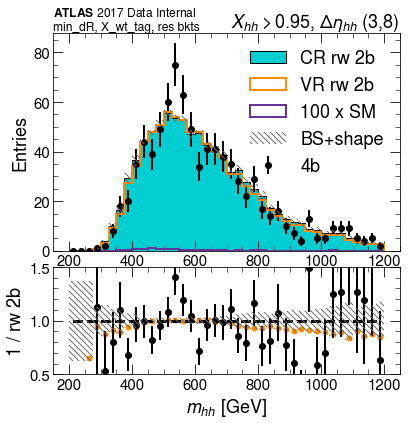

In [23]:
for mi,si,title,l in zip([sr.Xhh_new < 0.95, sr.Xhh_new > 0.95],
                      [sdf.Xhh_new < 0.95, sdf.Xhh_new > 0.95],
                     ['$X_{hh} < 0.95$','$X_{hh} > 0.95$'],['in','out']):
    for i, eta_min, eta_max in zip(range(2),edgs2[:-1],edgs2[1:]):
        
        mj = (sr.dEta_hh > eta_min) & (sr.dEta_hh < eta_max)
        smask = si & (sdf.dEta_hh>eta_min) & (sdf.dEta_hh<eta_max)
        
        evalRw(sr,'m_hh',40,[200,1200],
               title+', $\Delta \eta_{hh}$ '+f'({eta_min},{eta_max})',
               '$m_{hh}$ [GeV]',mi & mj,sdf=sdf[smask], 
               figDir=figDir,label=f'_SR{l}_2bins_{i}')

Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask


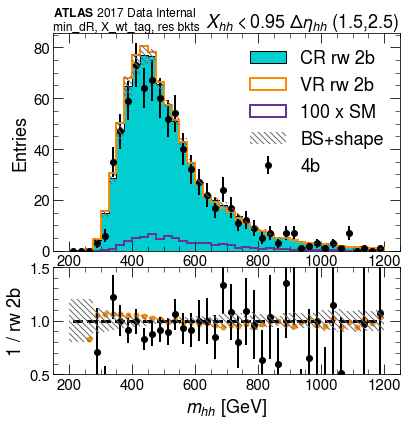

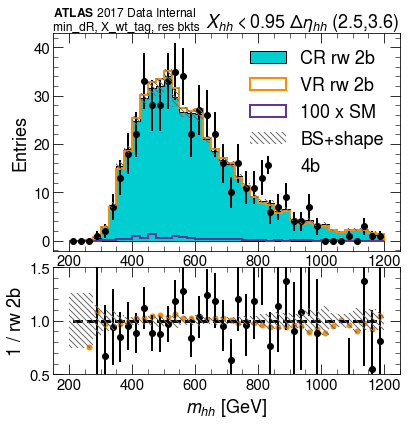

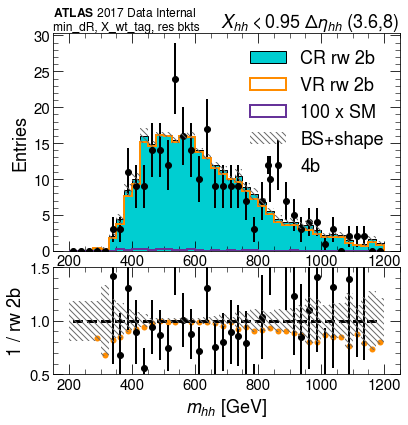

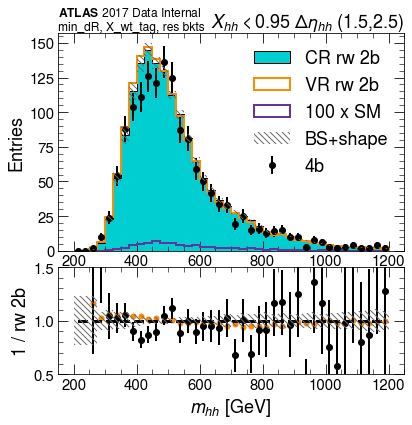

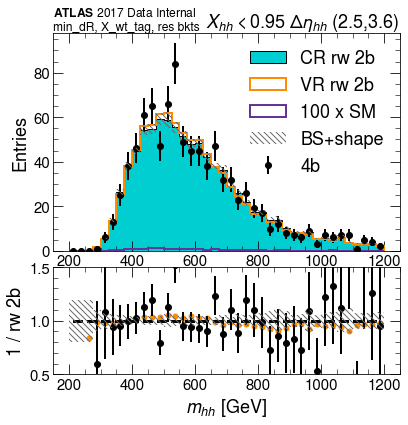

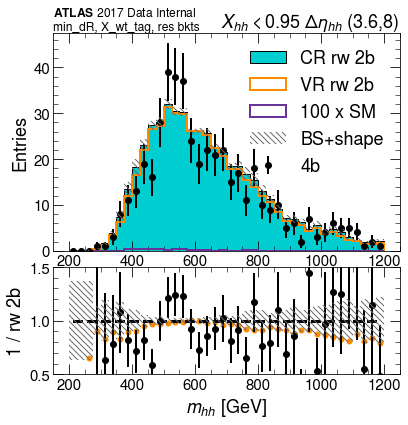

In [24]:
for mi,si,title,l in zip([sr.Xhh_new < 0.95, sr.Xhh_new > 0.95],
                         [sdf.Xhh_new < 0.95, sdf.Xhh_new > 0.95],
                         ['$X_{hh} < 0.95$','$X_{hh} < 0.95$'],
                         ['in','out']):
    
    for i,eta_min, eta_max in zip(range(3),edgs3[:-1],edgs3[1:]):
        
        mj = (sr.dEta_hh > eta_min) & (sr.dEta_hh < eta_max)
        
        smask = si & (sdf.dEta_hh>eta_min) & (sdf.dEta_hh<eta_max)
        
        evalRw(sr,'m_hh',40,[200,1200],
               title+' $\Delta \eta_{hh}$ '+f'({eta_min},{eta_max})',
               '$m_{hh}$ [GeV]',mi & mj,sdf=sdf[smask],
               figDir=figDir,label=f'_SR{l}_3bins_{i}')

The bootstrap errors are interestingly quite a bit larger now, but I think this is *encouraging* for our studies for deciding whether or not we'll want to correlate these.

Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask
Running bs w/ corresponding mask


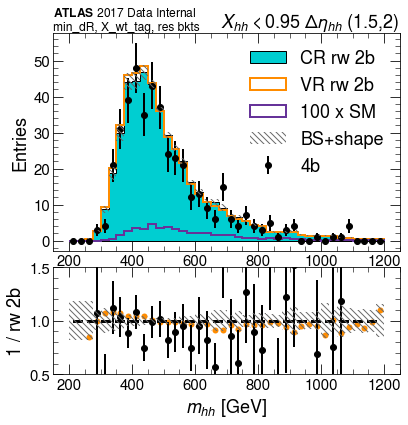

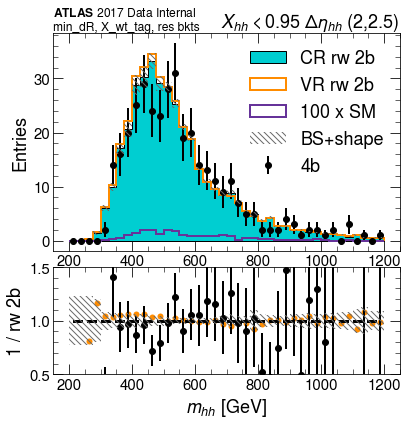

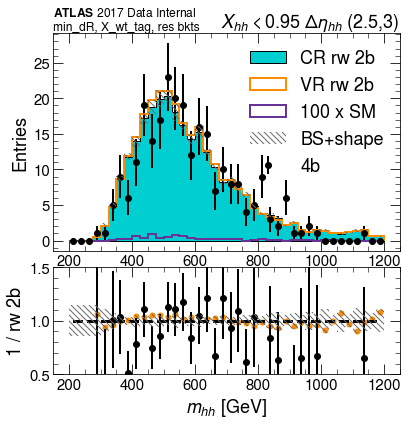

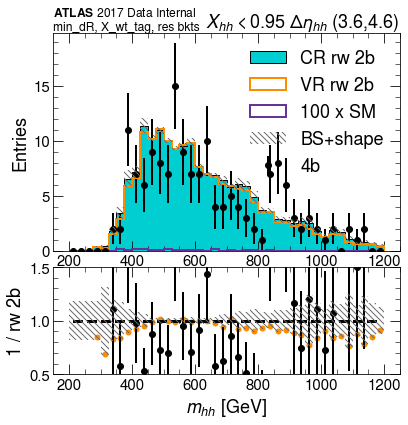

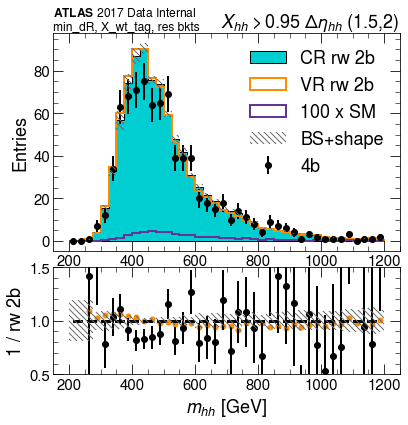

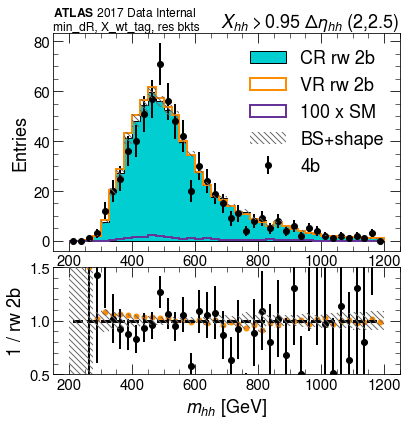

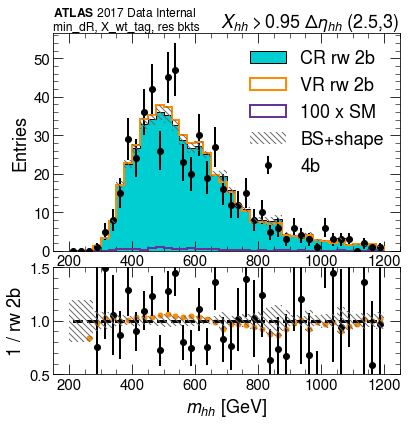

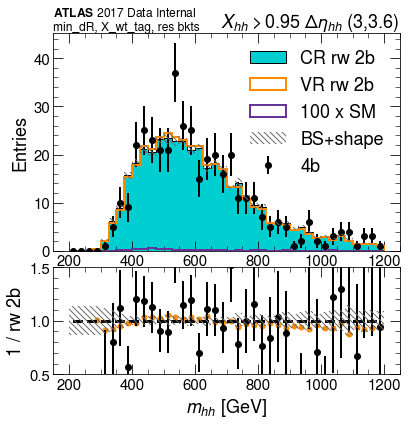

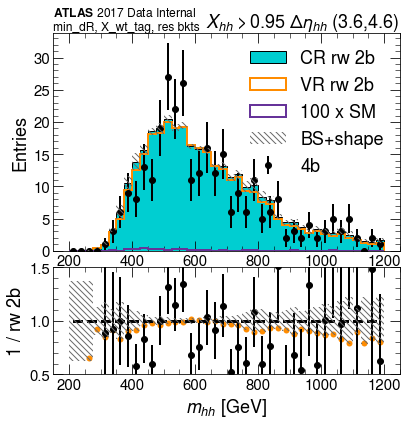

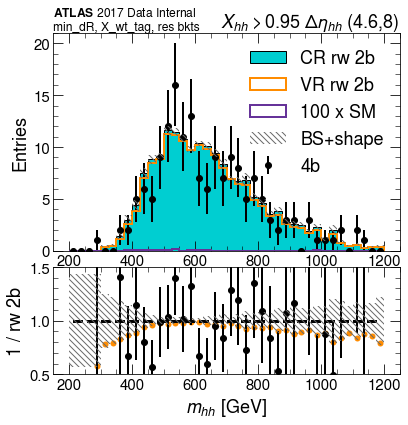

In [25]:
for mi,si,title,l in zip([sr.Xhh_new < 0.95, sr.Xhh_new > 0.95],
                         [sdf.Xhh_new < 0.95, sdf.Xhh_new > 0.95],
                         ['$X_{hh} < 0.95$','$X_{hh} > 0.95$'],['in','out']):
    for i,eta_min, eta_max in zip(range(6),edgs6[:-1],edgs6[1:]):
        
        mj = (sr.dEta_hh > eta_min) & (sr.dEta_hh < eta_max)
        
        smask = si & (sdf.dEta_hh>eta_min) & (sdf.dEta_hh<eta_max)
        
        evalRw(sr,'m_hh',40,[200,1200],
               title+' $\Delta \eta_{hh}$ '+f'({eta_min},{eta_max})',
               '$m_{hh}$ [GeV]',mi & mj,sdf=sdf[smask],
               figDir=figDir,label=f'_SR{l}_6bins_{i}')

These are pre-fit rn, ofc post-fit could be a lot better.